In [2]:
import subprocess
import os
import logging
import re
import itertools
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np

# Add path to hicreppy

In [19]:
environment_name = 'hicreppy'
environment_path = f"/users/michael.mitter/.conda/envs/{ environment_name }/bin/"

# get pre-set PATH environment variable
original_os_path = os.environ.get('PATH')
os_path = original_os_path

# guard PATH against multiple prepending
if environment_path not in original_os_path:
    os_path = environment_path + ':' + original_os_path
%env PATH=$os_path

env: PATH=/users/michael.mitter/.conda/envs/hicreppy/bin/:/software/2020/software/anaconda3/2019.03/bin;/software/2020/software/anaconda3/2019.03/condabin;/software/2020/software/anaconda3/2019.03/library/bin;/software/2020/software/anaconda3/2019.03/bin;/software/2020/software/anaconda3/2019.03/condabin;/software/2020/software/anaconda3/2019.03/library/bin;/software/2020/software/anaconda3/2019.03/bin;/software/2020/software/anaconda3/2019.03/condabin;/software/2020/software/anaconda3/2019.03/library/bin;/users/michael.mitter/.vscode-server/bin/5763d909d5f12fe19f215cbfdd29a91c0fa9208a/bin:/users/michael.mitter/.conda/envs/gitEnv/bin/:/users/michael.mitter/.vscode-server/bin/5763d909d5f12fe19f215cbfdd29a91c0fa9208a/bin:/software/2020/software/anaconda3/2019.03/condabin:/users/michael.mitter/.conda/envs/gitEnv/bin/:/software/system/utils:/usr/local/bin:/usr/bin:/groups/gerlich/members/MichaelMitter/UCSC_usertools/:/groups/gerlich/members/MichaelMitter/PythonPackages/OnTAD/:/usr/local/sb

# Define plotting parameters

In [3]:
matplotlib.rcParams.update({"pdf.fonttype": 42})

# Define Samples

In [20]:
def runSCC(fileIterator, binSize, maxdist=100000, subsample=0):
    """runs hicreppy scc on a pair of file returned
    by fileIterator for files located in fileDir."""
    # dispatch processes
    processList = []
    for file1, file2 in fileIterator:
        mat1 = f"{file1}::/resolutions/{binSize}"
        mat2 = f"{file2}::/resolutions/{binSize}"
        command = f"hicreppy scc -m {maxdist} -s {subsample} {mat1} {mat2}"
        processList.append((file1, file2, subprocess.Popen(command, stdout=subprocess.PIPE,
                                                           stderr=subprocess.STDOUT, shell=True)))
    # query if processes are finished and store results in list
    resultList = []
    while len(processList) != 0:
        for index, p in enumerate(processList):
            result = p[2].poll()
            if result is not None:
                output, err = p[2].communicate()
                for line in output.decode("UTF-8").split("\n"):
                    logging.info(line)
                    try:
                        value = float(line.strip())
                    except ValueError:
                        pass
                    else:
                        barcode1 = p[0].split("/")[-1].split(".1000.mcool")[0]
                        barcode2 = p[1].split("/")[-1].split(".1000.mcool")[0]
                        resultList.append(
                            {"barcode1": barcode1, "barcode2": barcode2, "sccR": value})
                logging.info("\n\n")
                processList.pop(index)
    return pd.DataFrame(resultList)


# Define regexes

In [7]:
CISSAMPLES = re.compile(r'.*S\d+.cis.1000.mcool')
TRANSSAMPLES = re.compile(r'.*S\d+.trans.1000.mcool')
ALLSAMPLES = re.compile(r'.*S\d+.all.1000.mcool')

# Define HiC sample directory

In [8]:
HICDIR = "/groups/gerlich/experiments/Experiments_004800/004812/Sequencing_data/Pooled_FC_1_2_3_4/cooler"

cisFiles = [os.path.join(HICDIR, i) for i in filter(CISSAMPLES.match, os.listdir(HICDIR))]
transFiles = [os.path.join(HICDIR, i) for i in filter(TRANSSAMPLES.match, os.listdir(HICDIR))]
allFiles = [os.path.join(HICDIR, i) for i in filter(ALLSAMPLES.match, os.listdir(HICDIR))]

# Add in first two replicates

In [9]:
HICDIROLD1 = "/groups/gerlich/experiments/Experiments_004600/004661/Sequencing_data/cooler/exp4605/"
HICDIROLD2 = "/groups/gerlich/experiments/Experiments_004600/004661/Sequencing_data/cooler/exp4615/"
cisFilesOld = [os.path.join(HICDIROLD1, "GCCAAT.cis.1000.mcool"), os.path.join(HICDIROLD2, "GTGAAA.cis.1000.mcool")]
transFilesOld = [os.path.join(HICDIROLD1, "GCCAAT.trans.1000.mcool"), os.path.join(HICDIROLD2, "GTGAAA.trans.1000.mcool")]
allFilesOld = [os.path.join(HICDIROLD1, "GCCAAT.all.1000.mcool"), os.path.join(HICDIROLD2, "GTGAAA.all.1000.mcool")]

In [10]:
cisFilesFin = cisFiles + cisFilesOld
transFilesFin = transFiles + transFilesOld
allFilesFin = allFiles + allFilesOld

# Define HiCRep parameters

In [12]:
maxdist = 1000000

# Compare files

In [21]:
allFilesComb = itertools.combinations(allFiles, r=2)
allResultsAll = runSCC(allFilesComb, 100000, maxdist, subsample=0)
allResultsAll.loc[:, "type"] = "all"
allResultsAll.loc[:, "maxdist"] = maxdist

In [22]:
cisFilesComb = itertools.combinations(cisFiles,r=2)
cisResultsAll = runSCC(cisFilesComb, 100000, maxdist, subsample=0)
cisResultsAll.loc[:, "type"] = "cis"
cisResultsAll.loc[:, "maxdist"] = maxdist

In [23]:
transFilesComb = itertools.combinations(transFiles, r=2)
transResultsAll = runSCC(transFilesComb, 100000, maxdist, subsample=0)
transResultsAll.loc[:, "type"] = "trans"
transResultsAll.loc[:, "maxdist"] = maxdist

In [24]:
cisTransFilesComb = itertools.product(cisFiles, transFiles)
cisTransResultsAll = runSCC(cisTransFilesComb, 100000, maxdist, subsample=0)
cisTransResultsAll.loc[:, "type"] = "cis/trans"
cisTransResultsAll.loc[:, "maxdist"] = maxdist

In [25]:
finFrameAll = pd.concat((cisResultsAll, transResultsAll, cisTransResultsAll, allResultsAll))
finFrameAll

,barcode1,barcode2,sccR,type,maxdist
0,AGTTCC_S8.cis,TTAGGC_S2.cis,0.978541,cis,1000000
1,CAGATC_S3.cis,AGTCAA_S7.cis,0.990956,cis,1000000
2,CAGATC_S3.cis,TTAGGC_S2.cis,0.984970,cis,1000000
3,TAGCTT_S6.cis,TTAGGC_S2.cis,0.989484,cis,1000000
4,ACTTGA_S4.cis,CAGATC_S3.cis,0.992228,cis,1000000
...,...,...,...,...,...
19,CCGTCC_S10.all,ACTTGA_S4.all,0.994635,all,1000000
20,ATGTCA_S9.all,GATCAG_S5.all,0.982087,all,1000000
21,ATGTCA_S9.all,AGTTCC_S8.all,0.993987,all,1000000
22,ATGTCA_S9.all,TAGCTT_S6.all,0.983218,all,1000000


## Plot

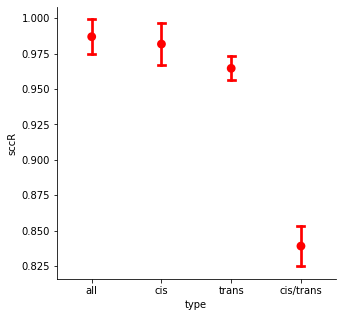

In [26]:
f, ax = plt.subplots()
#sbn.swarmplot(x="type", y="sccR", data=finFrameAll, ax=ax, color="black", alpha=0.2, order=["all", "cis", "trans", "cis/trans"])
sbn.pointplot(x="type", y="sccR", data=finFrameAll, ax=ax, color="red", alpha=1, join=False, ci="sd", capsize=0.1, order=["all", "cis", "trans", "cis/trans"])
sbn.despine()
f.set_size_inches(5, 5)
plt.show()

## Write to file

In [27]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/"
f.savefig(os.path.join(resultsdir, "HiC_Rep_WT_wOldData.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "HiC_Rep_WT_wOldData.pdf"), bbox_inches="tight")

# Plot barplot of all cis and trans

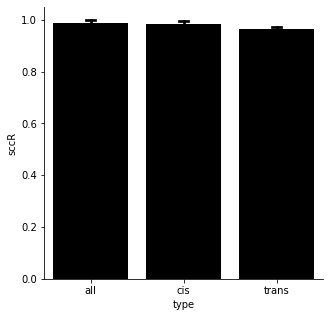

In [28]:
f, ax = plt.subplots()
#sbn.swarmplot(x="type", y="sccR", data=finFrameAll, ax=ax, color="black", alpha=0.2, order=["all", "cis", "trans", "cis/trans"])
sbn.barplot(x="type", y="sccR", data=finFrameAll.loc[finFrameAll["type"] != "cis/trans", :], ax=ax, color="black", alpha=1,  ci="sd", capsize=0.1, order=["all", "cis", "trans"], errcolor="black")
sbn.despine()
f.set_size_inches(5, 5)
plt.show()

In [29]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/"
f.savefig(os.path.join(resultsdir, "HiC_Rep_WT_bar_wocis_trans_wOldData.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "HiC_Rep_WT_bar_wocis_trans_wOldData.pdf"), bbox_inches="tight")

# Plot barplot with individual points

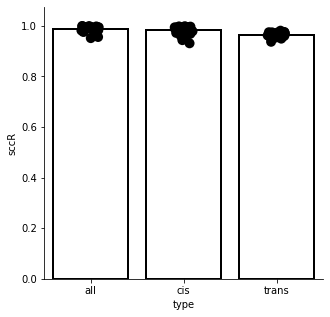

In [40]:
f, ax = plt.subplots()
sbn.barplot(x="type", y="sccR", data=finFrameAll.loc[finFrameAll["type"] != "cis/trans", :], ax=ax, color="black",facecolor=(1, 1, 1, 0) , linewidth=2,edgecolor="black", order=["all", "cis", "trans"])
sbn.stripplot(x="type", y="sccR", data=finFrameAll.loc[finFrameAll["type"] != "cis/trans", :], color="black", size=10, jitter=0.1, ax=ax, order=["all", "cis", "trans"])
sbn.despine()
sbn.despine()
f.set_size_inches(5, 5)
plt.show()

In [35]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/"
f.savefig(os.path.join(resultsdir, "HiC_Rep_WT_bar_wocis_trans_wOldData_indPoints.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "HiC_Rep_WT_bar_wocis_trans_wOldData_indPoints.pdf"), bbox_inches="tight")